Load dependencies

In [61]:
import jax
import jax.numpy as jnp
import optax
import IPython as ip
import matplotlib.pyplot as plt
from jax import random, grad, jit

Load image and define image sampling function for training

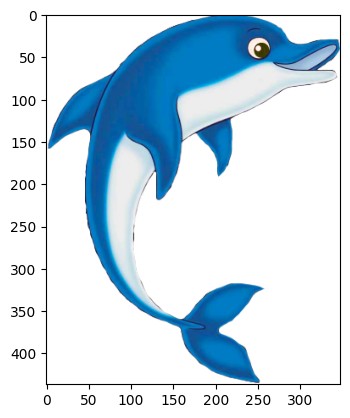

In [62]:
# Initialize random key
key = random.PRNGKey(28)

# Load and preview image normalized
# Separate color and alpha channel
img_rgba = jnp.array(plt.imread("dolphin_color.png"))
plt.imshow(img_rgba)
colors, mask = img_rgba[...,0:3], img_rgba[...,3].astype(bool)

# Define function to sample non transparent region of image
# when learning image
def sample_img(colors, mask, n_samples, key):
    
    # Extract n non-masked pixel coordinates (x) and colors (y)
    p_x, p_y = jnp.meshgrid(jnp.arange(img_rgba.shape[0]),jnp.arange(img_rgba.shape[1]), indexing='ij')
    p_x = jnp.stack((p_x, p_y),axis=-1)[mask]
    x = p_x[random.choice(random.split(key)[1], p_x.shape[0], (n_samples,))]
    y = colors[x[...,0], x[...,1]]
    x = x.at[...,0].divide(img_rgba.shape[0])
    x = x.at[...,1].divide(img_rgba.shape[1])

    return x, y

Network implementation and helper functions

### Network Structure Diagram
<p>Each layer is a tuple: <code>(weights, bias)</code></p>
<ul>
    <li><b>Weights</b> are stored as a <b>2D JAX array</b> (shape: [rows, cols])</li>
    <li><b>Bias</b> is stored as a <b>1D JAX array</b> (shape: [cols])</li>
</ul>

<pre style="font-family: monospace; padding: 10px; border-radius: 5px;">
        List of Layers
     ┌───────────────────┐
     │                   │
     ▼                   ▼
 ┌─────────┐       ┌─────────┐        ┌─────────┐
 │ Layer 0 │       │ Layer 1 │  ...   │ Layer n │
 └─────────┘       └─────────┘        └─────────┘
     │                   │                  │
     ▼                   ▼                  ▼
 ┌─────────────┐     ┌─────────────┐    ┌─────────────┐
 │ Tuple (W, b)│     │ Tuple (W, b)│    │ Tuple (W, b)│
 └─────────────┘     └─────────────┘    └─────────────┘
     │                   │                  │
     ▼                   ▼                  ▼
 ┌───────────────┐    ┌───────────────┐    ┌───────────────┐
 │ Weights (2D)  │    │ Weights (2D)  │    │ Weights (2D)  │
 │  JAX array    │    │  JAX array    │    │  JAX array    │
 └───────────────┘    └───────────────┘    └───────────────┘
     │                   │                  │
     ▼                   ▼                  ▼
 ┌───────────────┐    ┌───────────────┐    ┌───────────────┐
 │ Bias (1D)     │    │ Bias (1D)     │    │ Bias (1D)     │
 │ JAX array     │    │ JAX array     │    │ JAX array     │
 └───────────────┘    └───────────────┘    └───────────────┘
</pre>

In [84]:
# Initalize parameters of network (weights and biases)
def init_model_params(layers, key):
    keys = random.split(key, len(layers))
    params = []
    # For each Layer we have:
    # (k = key,
    # n_in = input dimension,
    # n_out = output dimension)
    for k, (n_in, n_out) in zip(keys, zip(layers[:-1], layers[1:])):
        W = random.normal(k, (n_in, n_out)) * 0.1
        b = jnp.zeros((n_out,))
        params.append((W, b))
    return params

# Forward input through the model to predict
def forward(params, x):
    for W, b in params:
        x = jax.nn.relu(jnp.dot(x, W) + b)
    return x

# Define loss function - Mean squared error loss
# Lambda defines in this case the batched arguments we want 
# to execute in parallel for the same function 
def loss(params, x, y):
    preds = jax.vmap(lambda x: forward(params, x))(x)
    return jnp.mean((preds - y) ** 2)

layer_sizes = [2, 16, 64, 128, 256, 128, 64, 16, 3]
params = init_model_params(layer_sizes, key)
opt = optax.adam(learning_rate=0.01)
opt_state = opt.init(params)

# Training step
@jit
def update(params, opt_state, x, y):
    grads = grad(loss)(params, x, y)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state

# Display image comparison between learned and original
def display_comparison(params):
    # Generate full predicted image
    H, W, C = colors.shape
    coords = jnp.indices((H, W)).reshape(2,-1).T
    coords = coords.at[...,0].divide(W)
    coords = coords.at[...,1].divide(H)
    pred_colors = jnp.clip(jax.vmap(lambda x: forward(params, x))(coords).reshape(H, W, C),0,1)

    # Display original and predicted image
    ip.display.clear_output(wait=True)
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(img_rgba)
    ax[0].set_title("Original")
    ax[1].imshow(pred_colors)
    ax[1].set_title("Predicted")
    for a in ax:
        a.axis("off")
    plt.tight_layout()
    plt.show()


Training loop

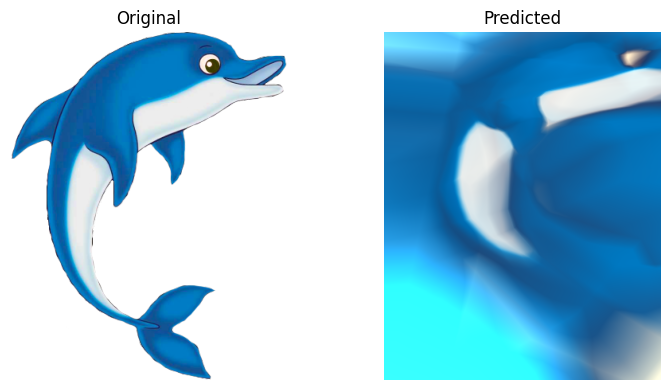

In [85]:
# Hyperparameter
num_epochs = 1000
batch_size = 10000

# Training loop
for epoch in range(num_epochs):
    x, y = sample_img(colors,mask,batch_size,key)
    params, opt_state = update(params, opt_state, x, y)
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss(params, x, y)}")
        display_comparison(params)
display_comparison(params)

